In [53]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

In [55]:
# to make this notebook's output stable across runs
np.random.seed(42)

In [89]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [90]:
X, y = mnist['data'], mnist['target']

In [91]:
X.shape

(70000, 784)

In [92]:
y.shape

(70000,)

In [93]:
# There are 70,000 images, with each of them having 784 features. This is because each image is 28 X 28 pixels.
# And each feature represents each pixels intensity, from 0 (white) to 255 (black). Let's take a peak at one of the digits.
# Grab an instance's feature vector, reshape it to a 28 X 28 array, and display it using Matplotlib.pyplot's imshow() function.

In [94]:
some_digit = X[3]
some_digit_image = some_digit.reshape((28, 28))

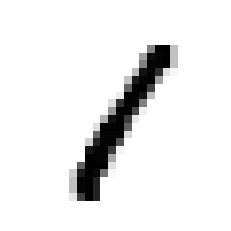

In [95]:
plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [96]:
y[3]

'1'

In [97]:
# Note that the label is a string. We need to convert it to a integer. 

y = y.astype(np.uint8)

In [98]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

In [99]:
# For now, lets just create a binary classifier that is capable of distinguishing just two classes, 5 and not-5.
# Lets create the target vectors for this class:

y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [100]:
# Now lets pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent (SGD) classifier. 
# This classifier has the advantage of handling large datasets efficiently, because SGD deals with training instances
# independently, one at a time (which also makes SGD sutiable for online learning).

In [101]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [102]:
sgd_clf.predict([some_digit])

array([False])

In [32]:
# Let's use cross_val_score() function to evaluate our Stochastic Gradient Descent classifier model, using K-fold
# cross-validation using 3 folds. 

In [33]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

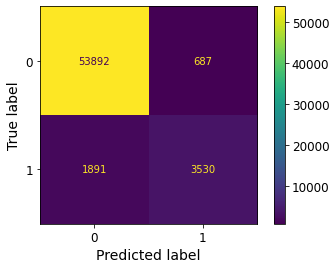

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

displ = ConfusionMatrixDisplay(confusion_matrix(y_train_5, y_train_pred))
displ.plot()

In [23]:
from sklearn.metrics import recall_score, precision_score, f1_score

# Recall (sensitivity) = TP / Total Actual Positives    = TP / (TP + FN)
# Precision            = TP / Total Predicted Positives = TP / (TP + FP)
# F1 score             = Harmonic mean of Recall and Precision

print('Recall score (sensitivity):', recall_score(y_train_5, y_train_pred))
print('Precision score:', precision_score(y_train_5, y_train_pred))
print('F1 score:', f1_score(y_train_5, y_train_pred))

Recall score (sensitivity): 0.6511713705958311
Precision score: 0.8370879772350012
F1 score: 0.7325171197343846


In [24]:
# F1 score favours classifiers that have similar precision and recall (sensitivity). This is not always the case.
# In some context we care about recall; in others we care about precision. 
# Consider two cases:
# 1. A model that detects whether a video is safe for kids or not: We want high precision.
# 2. A model to detect shoplifters in surveillance images: We want high recall.

# Increasing recall reduces precision and vice versa. This is the precision - recall trade-off. 

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-4623.84515943])

In [26]:
threshold = -5000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([ True])

In [27]:
threshold = 0
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

In [28]:
# How do you decide which threshold to use? First, use the cross_val_predict() to predict the decision function scores of all 
# the instances in the training set. 

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, method = 'decision_function')

In [29]:
from sklearn.metrics import precision_recall_curve

In [30]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [31]:
len(precisions), len(recalls), len(thresholds)

(59923, 59923, 59922)

In [32]:
precisions = precisions[:-1]
recalls = recalls[:-1]
len(precisions), len(recalls), len(thresholds)

(59922, 59922, 59922)

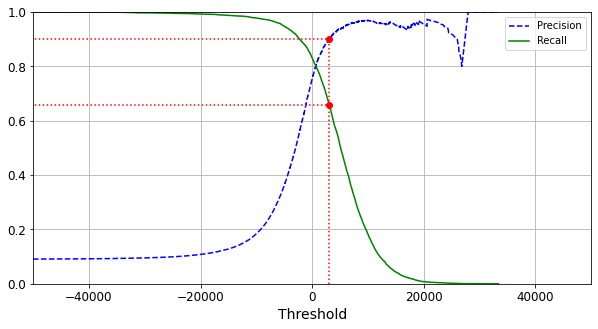

In [33]:
# Plotting the precision-recall threshold curve

p_r_t = pd.DataFrame({'precisions': list(precisions), 'recalls': list(recalls), 'thresholds': list(thresholds)})
plt.figure(figsize = (10,5))
plt.plot('thresholds', 'precisions', data = p_r_t, color = 'blue', linestyle = '--', label = 'Precision')
plt.plot('thresholds', 'recalls', data = p_r_t, color = 'green', linestyle = '-', label = 'Recall')
plt.legend(loc = 'best')
plt.xlabel('Threshold')
plt.axis([-50000, 50000, 0, 1])
plt.grid()

recall_90_precision = p_r_t['recalls'][np.argmax(p_r_t['precisions'] >= 0.90)]
threshold_90_precision = p_r_t['thresholds'][np.argmax(p_r_t['precisions'] >= 0.90)]

plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-80000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-80000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")


plt.show()

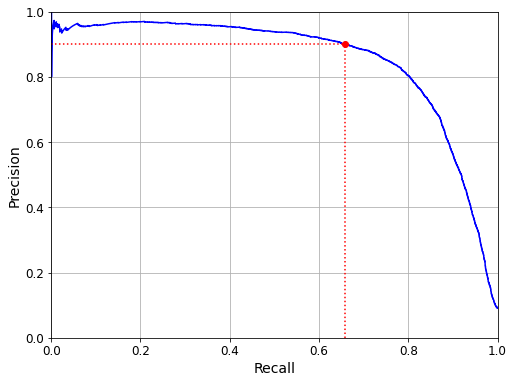

In [34]:
# Plotting Precision-recall curve

plt.figure(figsize=(8, 6))

plt.plot('recalls', 'precisions', data = p_r_t, color = 'blue')
plt.axis([0, 1, 0, 1])
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.grid()

plt.xlabel("Recall")
plt.ylabel("Precision")

plt.show()

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

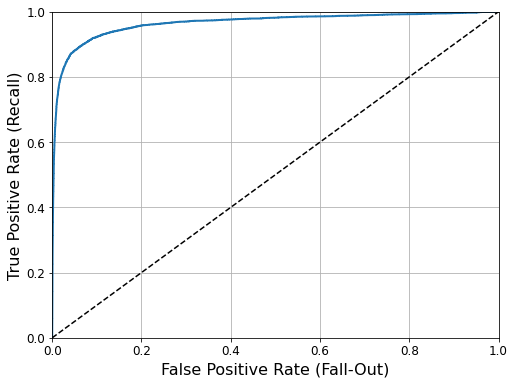

In [51]:
plt.figure(figsize=(8, 6))  
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') 
plt.axis([0, 1, 0, 1])                                    
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
plt.grid(True)
plt.show()

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9648211175804801

In [48]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')

In [49]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive classes
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

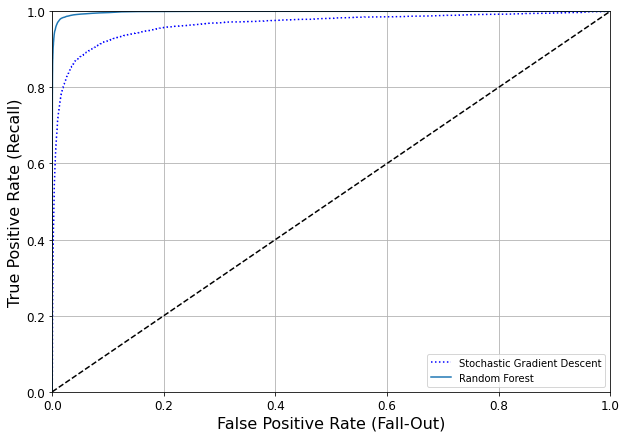

In [56]:
plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, 'b:', label = 'Stochastic Gradient Descent')
plt.plot(fpr_forest, tpr_forest, label = 'Random Forest')
plt.plot([0, 1], [0, 1], 'k--') 
plt.axis([0, 1, 0, 1])                                    
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
plt.grid(True)
plt.legend()
plt.show()

In [57]:
# Random Forest Classifier is superior to the SGD classifier because its ROC curve is much closer to the top-left corner,
# and it has greater AUC.

In [58]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [59]:
# 1. Choose appropriate metric for your class.
# 2. Evaluate your classifier using cross-validation.
# 3. Select the precision/recall trade-off that suits your model.
# 4. Use ROC curves and ROC AUC scores to compare various models.

# Multiclass Classification

In [65]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [66]:
sgd_clf.predict([some_digit])

array([1], dtype=uint8)

In [67]:
# decision_function() now gives us one value per class. 

sgd_clf.decision_function([some_digit])

array([[-2.36885257e+04,  6.69113543e+03, -4.98355753e+03,
        -2.34658323e+03, -8.38302025e+03, -6.93542749e+03,
        -2.49056060e+04, -1.14416973e+04, -1.48347142e+01,
        -7.44049520e+03]])

In [68]:
# You can see that the classifier is fairly confident about its prediction. All other scores are negative while class 1 has a 
# score of 6691.

In [69]:
# evaluating the performance of the classifier using cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [70]:
# For every fold, it is over 85%. 
# Let's try a random forest classifier.

cross_val_score(forest_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.9646 , 0.96255, 0.9666 ])

In [71]:
# We will now standardize the X_train set and then look at the accuracy for the 3 folds.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

In [72]:
# After scaling the X_train set, the accuracy for the folds increases.

In [74]:
# Creating a confusion matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3, method = 'predict')

In [75]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

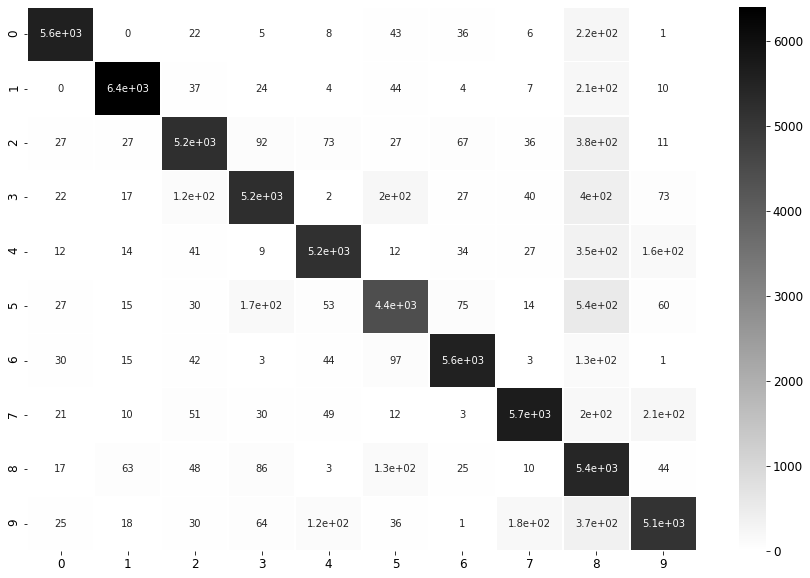

In [89]:
# Creating a heatmap of the confusion matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(conf_mx, annot = True, linewidths=.5, cmap="binary", ax = ax);

In [83]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

In [86]:
row_sums = np.sum(conf_mx, axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

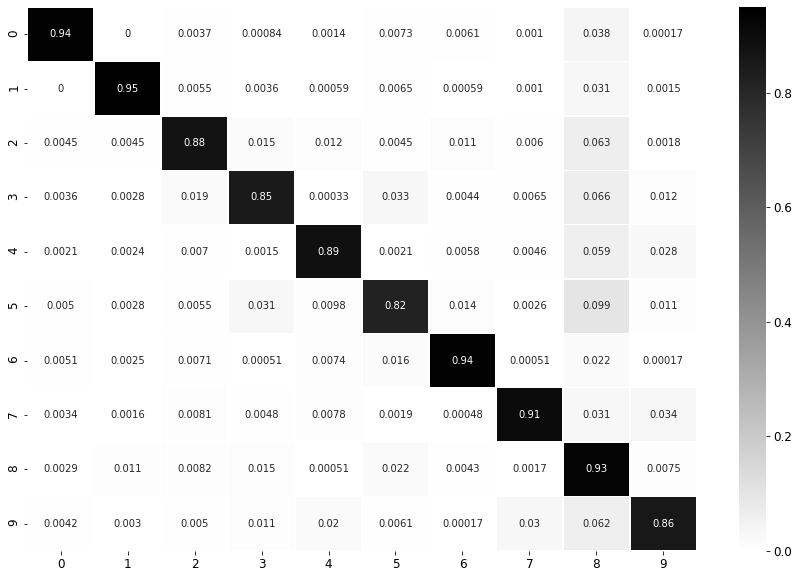

In [90]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(norm_conf_mx, annot = True, linewidths=.5, cmap="binary", ax = ax);

# Multilabel Classification

In [93]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [96]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_scaled, y_multilabel)

KNeighborsClassifier()

In [95]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train_scaled, y_multilabel, cv = 3)

In [ ]:
cross_val_score(knn_clf, X_train_scaled, y_multilabel, cv = 3, scoring = 'accuracy')